In [14]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import CMR_IA as cmr
import scipy as sp
sns.set_context('paper')
plt.style.use('default')
pd.set_option('display.max_columns', None)

In [15]:
params = cmr.make_default_params()
params.update(
    beta_enc = 0.5,
    beta_cue = 0.7, # overall accuracy important
    beta_distract = 0, 
    beta_rec_new = 0.1,
    beta_rec_post = 0.1,
    gamma_fc = 0.4,
    gamma_cf = 0.6, # unknown why
    s_fc = 0.4,
    s_cf = 0.4, # s_cf > s_fc
    c_thresh = 0.01,
    c_thresh_ass = 0.01,
    a = 2800,
    b = 2.14,
    m = 0,
    n = 1,
    kappa = 0.08,
    lamb = 0.04,
    eta = 0.01,
    alpha = 0.5,
    omega = 2,
    phi_s = 1,
    phi_d = 0.6,
    nitems_in_accumulator = 16, # must be 16
    d_ass = 0.6, # overall accuracy important
    No_recall = np.arange(0,8),
)
params

{'beta_enc': 0.5,
 'beta_rec': 0.5,
 'beta_cue': 0.7,
 'beta_rec_new': 0.1,
 'beta_rec_post': 0.1,
 'beta_distract': 0,
 'phi_s': 1,
 'phi_d': 0.6,
 's_cf': 0.4,
 's_fc': 0.4,
 'kappa': 0.08,
 'eta': 0.01,
 'omega': 2,
 'alpha': 0.5,
 'c_thresh': 0.01,
 'c_thresh_ass': 0.01,
 'd_ass': 0.6,
 'lamb': 0.04,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 16,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 2.14,
 'm': 0,
 'n': 1,
 'c1': 0,
 'No_recall': array([0, 1, 2, 3, 4, 5, 6, 7]),
 'var_enc': 1,
 'bad_enc_ratio': 1,
 'gamma_fc': 0.4,
 'gamma_cf': 0.6}

In [16]:
def simu_cr_similarity(params):

    # load stimuli
    with open("../Data/simu8b_design.pkl", 'rb') as inp:
        df_study = pickle.load(inp)
        df_test = pickle.load(inp)
    # df_study = df_study.loc[df_study.session < 1000]
    # df_test = df_test.loc[df_test.session < 1000]

    # load and get face distance
    face_distance = np.load('../Data/simu8_distance.npy')
    def get_distance(df_tmp):
        faces = np.unique(df_tmp.test_itemno)
        face_dist = {}
        for face in faces:
            this_dist = []
            for other_face in faces:
                if face != other_face:
                    this_dist.append(face_distance[face-1,other_face-1])
            this_dist = np.array(this_dist)
            face_dist[face] = this_dist
        y = df_tmp.apply(lambda x: face_dist[x['test_itemno']],axis=1)
        return y
    df_test['distance'] = df_test.groupby("session").apply(get_distance).to_frame(name='distance').reset_index()['distance']
    
    distance_thresh = 3
    df_test['neighbour'] = df_test.apply(lambda x: sum(x['distance'] < distance_thresh), axis=1)
    df_test['neighbour_group'] = df_test.apply(lambda x: 6 if x['neighbour'] == 7 else x['neighbour'], axis=1)

    # load semantic matrix
    s_mat = np.load('../Data/simu8_smat.npy')

    # run CMR
    df_simu, f_in, f_dif = cmr.run_norm_cr_multi_sess(params,df_study, df_test ,s_mat)
    df_simu = df_simu.merge(df_test,on=['session','list','test_itemno'])

    return df_simu

In [17]:
def anal_perform(df_simu):
    # get correction
    df_simu['correct'] = df_simu.s_resp == df_simu.correct_ans
    print("correct rate: ", sum(df_simu.correct)/len(df_simu.correct))

    # plt neighborhood effect (as paper)
    df_neighbour_group = df_simu.groupby("neighbour_group").correct.mean().reset_index()
    fig, ax = plt.subplots(figsize=(5,5))
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis="y",direction="in")
    ax.tick_params(axis="x",direction="in")
    sns.lineplot(data=df_neighbour_group.query("neighbour_group > 0"), x='neighbour_group', y='correct', linewidth=2, marker='o', markersize = 7)
    plt.ylim([0.4,1])
    plt.xlim([0.5,6.5])
    plt.xticks(ticks=np.arange(1,7), labels=['1','2','3','4','5','6-7'])
    plt.xlabel('Number of Neighbours')
    plt.ylabel('Probability of Correct Recall')
    # plt.savefig('fig/simu8_correct_neighbourgroup.pdf')
    plt.show()

    # get ILI
    df_simu['ITI'] = df_simu.apply(lambda x: True if x['correct'] == False and 17 <= x['s_resp'] <= 32 else False, axis=1)
    df_ILI = df_simu.loc[df_simu.ITI == True,:].copy()
    
    # get distance between ILI and correct faces
    face_distance = np.load('../Data/simu8_distance.npy')
    with open("../Data/simu8b_design.pkl", 'rb') as inp:
        df_study = pickle.load(inp)
    # df_study = df_study.loc[df_study.session < 1000]
    def get_resp_face(df_tmp):
        sess = np.unique(df_tmp.session).item()
        sess_name_face = df_study.query(f"session == {sess}")[["study_itemno1","study_itemno2"]].set_index("study_itemno2").to_dict()['study_itemno1']
        resp_face = df_tmp.apply(lambda x: sess_name_face[x['s_resp']],axis=1)
        return resp_face
    df_ILI['resp_face'] = df_ILI.groupby("session").apply(get_resp_face).to_frame().reset_index()[0].to_list()
    df_ILI['resp_corr_distance'] = df_ILI.apply(lambda x: face_distance[x['test_itemno']-1,x['resp_face']-1], axis=1)
    df_ILI['distance_bin'] = df_ILI.apply(lambda x: str(0.5 * (x['resp_corr_distance'] // 0.5 + 1)) if x['resp_corr_distance'] < 3.5 else ">3.5", axis=1)

    # count probability of ILI from all distance
    distance_cnt = {}
    for lst in df_ILI.distance:
        for d in lst:
            d_group = str(0.5 * (d // 0.5 + 1)) if d < 3.5 else ">3.5"
            if d_group in distance_cnt:
                distance_cnt[d_group] += 1
            else:
                distance_cnt[d_group] = 1
    df_ILI_distance = df_ILI.groupby("distance_bin")['test_itemno'].count().to_frame(name='ILI_cnt').reset_index()
    df_ILI_distance['ILI_poss'] = df_ILI_distance.apply(lambda x: distance_cnt[x['distance_bin']], axis=1)
    df_ILI_distance['ILI_prob'] = df_ILI_distance['ILI_cnt'] / df_ILI_distance['ILI_poss']

    # plot ILI by distance bin
    fig,ax = plt.subplots(figsize=(5,5))
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis="y",direction="in")
    ax.tick_params(axis="x",direction="in")
    sns.lineplot(data=df_ILI_distance, x='distance_bin', y='ILI_prob', linewidth=2, marker='o', markersize = 7)
    plt.ylim([0,0.25])
    plt.xlim([-1,6.5])
    plt.xlabel('Distance Bins')
    plt.ylabel('Probability of ILI')
    # plt.savefig('fig/simu8_ILI_distance.pdf')
    plt.show()

    return df_neighbour_group, df_ILI_distance

CMR2 Time: 74.43902683258057
correct rate:  0.6911125


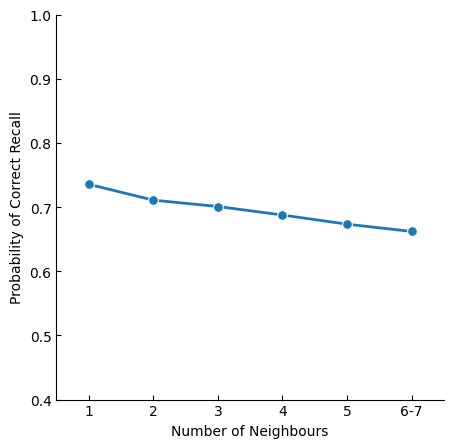

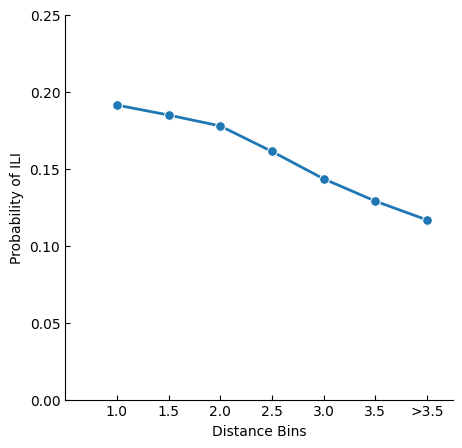

In [18]:
params.update(s_fc = 0.35, s_cf = 0.35)
df_simu_1 = simu_cr_similarity(params)
df_neighbour_group_1, df_ILI_distance_1 = anal_perform(df_simu_1)

CMR2 Time: 76.82893347740173
correct rate:  0.6973875


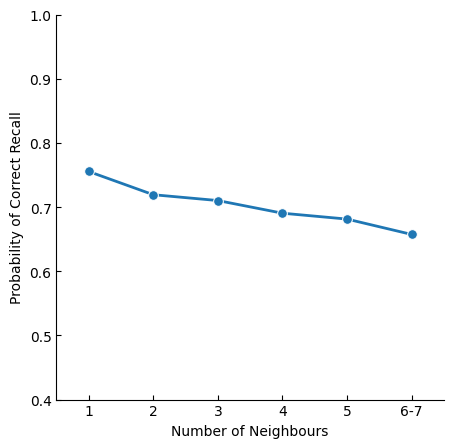

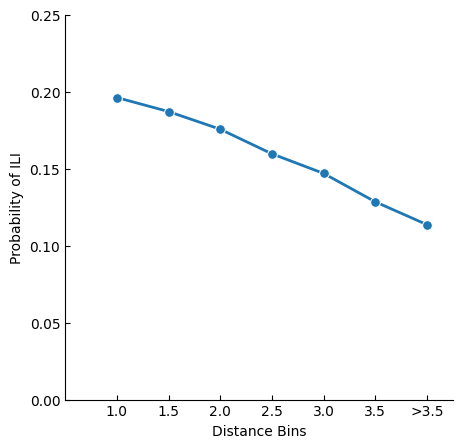

In [19]:
params.update(s_fc = 0.35, s_cf = 0.45)
df_simu_2 = simu_cr_similarity(params)
df_neighbour_group_2, df_ILI_distance_2 = anal_perform(df_simu_2)

CMR2 Time: 76.82891297340393
correct rate:  0.6960125


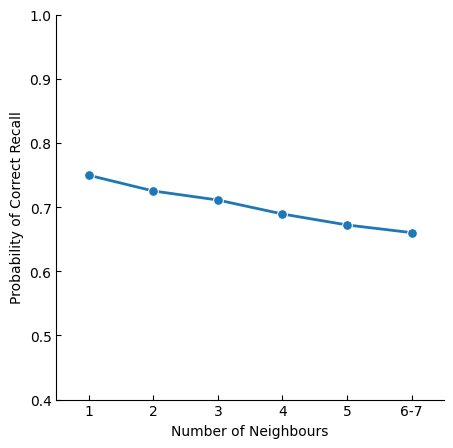

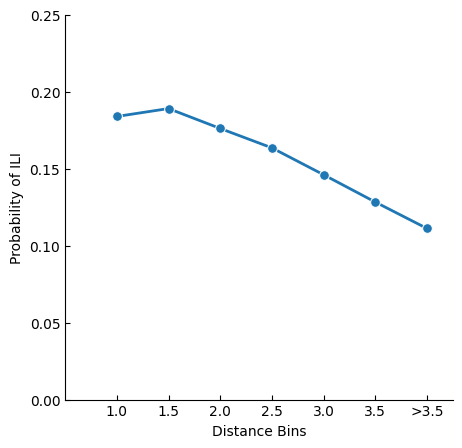

In [20]:
params.update(s_fc = 0.35, s_cf = 0.55)
df_simu_3 = simu_cr_similarity(params)
df_neighbour_group_3, df_ILI_distance_3 = anal_perform(df_simu_3)

CMR2 Time: 84.80599665641785
correct rate:  0.6958125


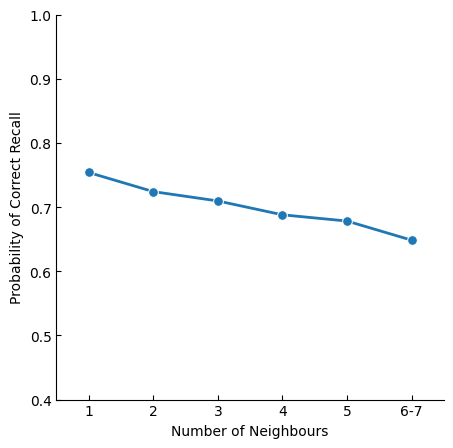

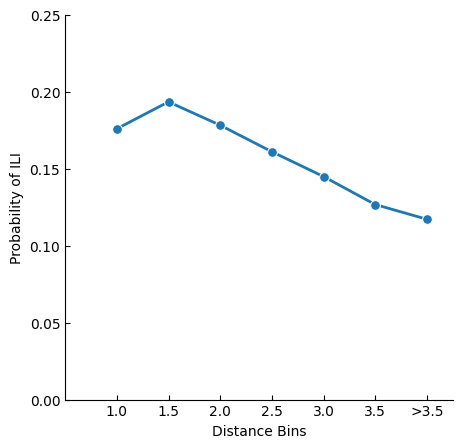

In [21]:
params.update(s_fc = 0.35, s_cf = 0.65)
df_simu_4 = simu_cr_similarity(params)
df_neighbour_group_4, df_ILI_distance_4 = anal_perform(df_simu_4)

In [22]:
df_neighbour = pd.DataFrame()
df_neighbour['neighbour_group'] = df_neighbour_group_1['neighbour_group']
df_neighbour['correct_1'] = df_neighbour_group_1['correct']
df_neighbour['correct_2'] = df_neighbour_group_2['correct']
df_neighbour['correct_3'] = df_neighbour_group_3['correct']
df_neighbour['correct_4'] = df_neighbour_group_4['correct']
df_neighbour

,neighbour_group,correct_1,correct_2,correct_3,correct_4
0,0,0.777293,0.772926,0.755459,0.786026
1,1,0.735547,0.755469,0.749609,0.753906
2,2,0.710823,0.719272,0.725106,0.724100
3,3,0.700886,0.710184,0.711003,0.709558
4,4,0.687639,0.690464,0.689213,0.687962
5,5,0.673361,0.681297,0.672140,0.678244
6,6,0.662056,0.657383,0.660187,0.648411


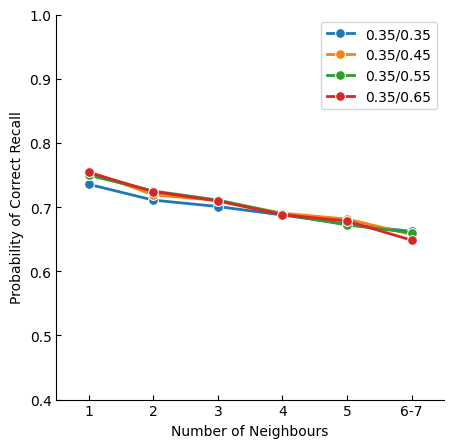

In [26]:
fig,ax = plt.subplots(figsize=(5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_neighbour.query("neighbour_group > 0"), x='neighbour_group', y='correct_1', 
             linewidth=2, marker='o', markersize = 7, color = 'C0', label='0.35/0.35')
sns.lineplot(data=df_neighbour.query("neighbour_group > 0"), x='neighbour_group', y='correct_2', 
             linewidth=2, marker='o', markersize = 7, color = 'C1', label='0.35/0.45')
sns.lineplot(data=df_neighbour.query("neighbour_group > 0"), x='neighbour_group', y='correct_3', 
             linewidth=2, marker='o', markersize = 7, color = 'C2', label='0.35/0.55')
sns.lineplot(data=df_neighbour.query("neighbour_group > 0"), x='neighbour_group', y='correct_4', 
             linewidth=2, marker='o', markersize = 7, color = 'C3', label='0.35/0.65')
plt.ylim([0.4,1])
plt.xlim([0.5,6.5])
plt.xticks(ticks=np.arange(1,7), labels=['1','2','3','4','5','6-7'])
plt.xlabel('Number of Neighbours')
plt.ylabel('Probability of Correct Recall')
plt.savefig('fig/simu8_4line_correct.pdf')
plt.show()

In [24]:
df_ILI = pd.DataFrame()
df_ILI['distance_bin'] = df_ILI_distance_1['distance_bin']
df_ILI['ILI_prob_1'] = df_ILI_distance_1['ILI_prob']
df_ILI['ILI_prob_2'] = df_ILI_distance_2['ILI_prob']
df_ILI['ILI_prob_3'] = df_ILI_distance_3['ILI_prob']
df_ILI['ILI_prob_4'] = df_ILI_distance_4['ILI_prob']
df_ILI

,distance_bin,ILI_prob_1,ILI_prob_2,ILI_prob_3,ILI_prob_4
0,1.0,0.191250,0.196135,0.183848,0.175856
1,1.5,0.184793,0.187037,0.188975,0.193338
2,2.0,0.177686,0.175566,0.176060,0.178151
3,2.5,0.161155,0.159611,0.163466,0.160958
4,3.0,0.143389,0.146892,0.146032,0.144836
5,3.5,0.128907,0.128457,0.128306,0.126675
6,>3.5,0.116674,0.113619,0.111169,0.117097


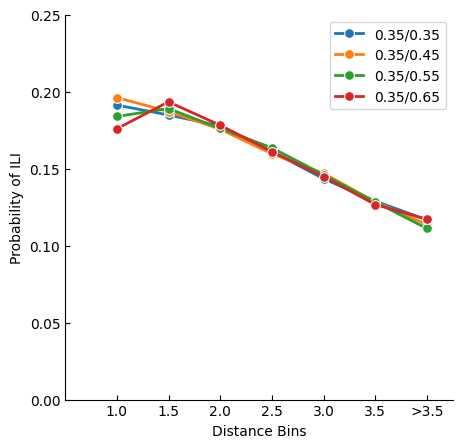

In [27]:
# ILI by distance bin
fig,ax = plt.subplots(figsize=(5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_ILI, x='distance_bin', y='ILI_prob_1', 
             linewidth=2, marker='o', markersize = 7, color='C0', label='0.35/0.35')
sns.lineplot(data=df_ILI, x='distance_bin', y='ILI_prob_2', 
             linewidth=2, marker='o', markersize = 7, color='C1', label='0.35/0.45')
sns.lineplot(data=df_ILI, x='distance_bin', y='ILI_prob_3', 
             linewidth=2, marker='o', markersize = 7, color='C2', label='0.35/0.55')
sns.lineplot(data=df_ILI, x='distance_bin', y='ILI_prob_4', 
             linewidth=2, marker='o', markersize = 7, color='C3', label='0.35/0.65')
plt.ylim([0,0.25])
plt.xlim([-1,6.5])
plt.xlabel('Distance Bins')
plt.ylabel('Probability of ILI')
plt.savefig('fig/simu8_4line_ILI.pdf')
plt.show()